# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import glob

import math
import random

import csv
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from cnn import LeNet
import tensorflow as tf
from tensorflow.contrib.layers import flatten

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# TODO: Fill this in based on where you saved the training and testing data
show_images = True
perform_train = True
data_dir = './traffic-signs-data/'
save_filename = './traffic_classifier'

def load_sign_names():
    """
    Load the sign names into a dictionary
    :return: a dictionary with the sign id and names 
    """
    with open('signnames.csv') as sign_names_file:
        reader = csv.reader(sign_names_file)
        next(reader, None)
        return {int(row[0]):row[1] for row in reader}


sign_names = load_sign_names()

def load_data(dir):
    training_file = os.path.join(dir, 'train.p')
    validation_file = os.path.join(dir, 'valid.p')
    testing_file = os.path.join(dir, 'test.p')
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    X_train, y_train = train['features'], train['labels']
    X_valid, y_valid = valid['features'], valid['labels']
    X_test, y_test = test['features'], test['labels']
    return train, X_train, y_train, X_valid, y_valid, X_test, y_test

train, X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(data_dir)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.

n_classes = len(set(y_train).union(set(y_valid).union(set(y_test))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
def show_random_image(img, cmap=None):
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap=cmap)


def plot_count_signals(data, set_name):
    signals, count = np.unique(data, return_counts=True)
    n_groups = len(count)

    # Create a figure and a set of subplots
    # This utility wrapper makes it convenient to create
    # common layouts of subplots, including the enclosing figure object, in a single call.

    index = np.arange(n_groups)
    bar_width = 0.35

    opacity = 0.4

    plt.bar(index, count, bar_width,
            alpha=opacity,
            color='b',
            label='Signals')

    plt.xlabel('Signal Id')
    plt.ylabel('Count')
    plt.title('{}: {}'.format(set_name, 'Samples per signal'))
    plt.legend()


def show_histogram(img):
    hist, bin_edges = np.histogram(img, bins=60)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.figure(figsize=(11, 4))

    plt.subplot(132)
    plt.plot(bin_centers, hist, lw=2)
    plt.title('Histogram')
    plt.axvline(0.5, color='r', ls='--', lw=2)
    plt.yticks([])
    plt.subplots_adjust(wspace=0.02, hspace=0.3, top=1, bottom=0.1, left=0, right=1)
    if show_images:
        plt.show()


def get_random_image(data):
    index = random.randint(0, len(data))
    return data[index].squeeze(), index


def visualize_desc_data():
    global image, index
    image, index = get_random_image(X_train)
    show_random_image(image)
    print('{}: {}'.format('Index', y_train[index]))
    show_histogram(image)

    plt.hist(y_train, n_classes)
    if show_images:
        plt.show()

        
def visualize_dataset():
    plt.figure(figsize=(18, 18))
    for i in range(0, n_classes):
        plt.subplot(11, 4, i + 1)
        x_selected = X_train[y_train == i]
        plt.imshow(x_selected[0, :, :, :])
        plt.title('{} - {}'.format(i, sign_names[i]))
        plt.axis('off')
    plt.tight_layout()
    if show_images:
        plt.show()


Index: 6


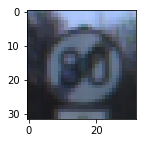

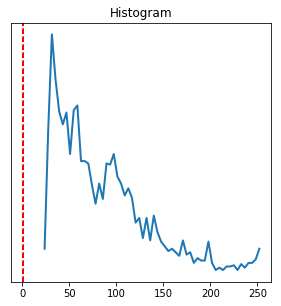

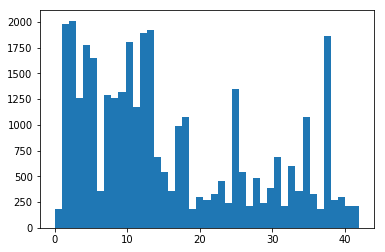

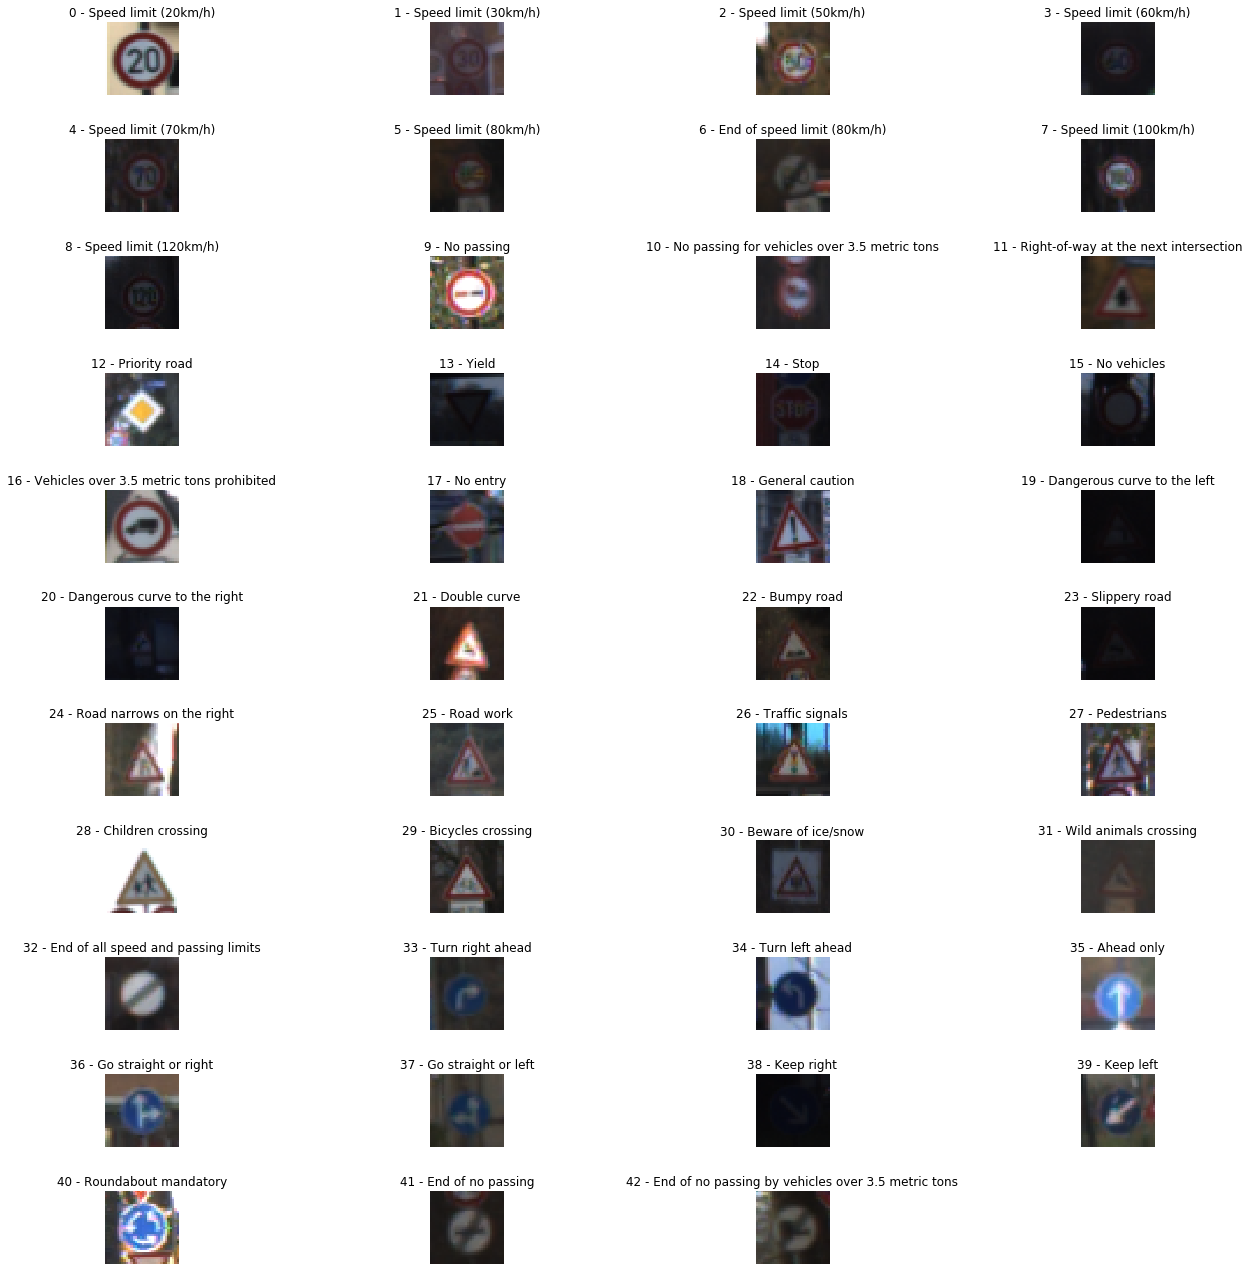

In [4]:
visualize_desc_data()
visualize_dataset()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
# http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
# http://en.wikipedia.org/wiki/Normalization_%28image_processing%29

def normalize_data(data):
    return data / 255 * 0.8 + 0.1


def convert_gray(data):
    # cvtColor return 32x32
    converted = []
    for row in data:
        converted.append(cv2.cvtColor(row, cv2.COLOR_BGR2GRAY))
    return np.array(converted)


def rotate_image(img):
    num_rows, num_cols = img.shape[:2]
    grades = random.randint(-10, 10)
    rotation_matrix = cv2.getRotationMatrix2D((num_cols / 2, num_rows / 2), grades, 1)
    return cv2.warpAffine(img, rotation_matrix, (num_cols, num_rows))


def rotate_dataset(data):
    """
    Only adds rotation to those images under represented in the dataset
    :param data: the current dataset
    :return: an array of images rotated
    """
    converted = []
    for row in data:
        converted.append(rotate_image(row))
    return np.array(converted)


def apply_histogram_eq(data):
    """
    http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    :param data:
    :return:
    """
    converted = []
    for row in data:
        converted.append(cv2.equalizeHist(row))
    return np.array(converted)

def apply_gaussian_blur(image):
    """
    Smooth image by applying Gaussian blur
    :param image: the original image
    :return: a new image 
    """
    return cv2.GaussianBlur(image, (5,5), 0)

In [6]:
# Extend the dataset
X_train = convert_gray(X_train)
X_train = apply_histogram_eq(X_train)
X_train = X_train[..., np.newaxis]
X_train = normalize_data(X_train)

X_valid = convert_gray(X_valid)
X_valid = apply_histogram_eq(X_valid)
X_valid = X_valid[..., np.newaxis]
X_valid = normalize_data(X_valid)

# X_test must be converted and normalized too
X_test = convert_gray(X_test)
X_test = apply_histogram_eq(X_test)
X_test = X_test[..., np.newaxis]
X_test = normalize_data(X_test)

In [7]:

# Extend the dataset
X_train_augmented = []
y_train_augmented = []


def augment_class(mean, class_count):
    """
    Augment the number of samples for classes with 
    """
    # print('{} {} {}'.format('Augmenting class', class_count[0], math.ceil(mean - class_count[1])))
    image = X_train[class_count[0]]
    for i in range(0, math.ceil(mean - class_count[1])):
        rotated_image = rotate_image(image)
        X_train_augmented.append(rotated_image)
        y_train_augmented.append(class_count[0])
        
# Obtain the mean of the number of classes as shown in the histogram
# Then for each class with count under the mean, add rotation

# bincount: Count number of occurrences of each value in array of non-negative ints.
# Each bin gives the number of occurrences of its index value in x. If weights is specified the input array
# is weighted by it, i.e. if a value n is found at position i, out[n] += weight[i] instead of out[n] += 1.
count_per_class = np.bincount(y_train)
print(np.bincount(y_train))
mean = np.mean(count_per_class)
print('{} => {}'.format('Mean of y_valid', mean))

# TODO Pythonise this
idx = np.where(count_per_class < mean)[0]
low_values = count_per_class[idx]

[augment_class(mean, x) for x in zip(idx, low_values)]

X_train_augmented = np.array(X_train_augmented)[Ellipsis, np.newaxis]
X_train = np.append(X_train, X_train_augmented, axis=0)
y_train = np.append(y_train, np.array(y_train_augmented), axis=0)

print(X_train.shape)
print(y_train.shape)


[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920  690
  540  360  990 1080  180  300  270  330  450  240 1350  540  210  480  240
  390  690  210  599  360 1080  330  180 1860  270  300  210  210]
Mean of y_valid => 809.2790697674419
(46740, 32, 32, 1)
(46740,)


In [8]:
def add_transformations(original_image):
    """
    Augment the train dataset by adding modifications to each image
    :param original_image: the image to be transformed 
    :return: a list of images each being a transformation of the original one
    """
    rotated = rotate_image(original_image)
    blurred = apply_gaussian_blur(original_image)
    # contrast = increase_contrast(original_image)
    return rotated, blurred

# X_train_augmented, y_train_augmented = [add_transformations(x, y) for x, y in zip(X_train, y_train)]


def augment_dataset():
    new_X_train = []
    new_y_train = []
    for index in range(0, len(X_train)):
        transforms = add_transformations(X_train[index])
        new_X_train.extend(transforms)
        new_y_train+= len(transforms) * [y_train[index]]
    return new_X_train, new_y_train

# Augmenting the train dataset
X_train_augmented, y_train_augmented = augment_dataset()
print('{} {} {}'.format('Augmented dataset', len(X_train_augmented), len(y_train_augmented)))

X_train_augmented = np.array(X_train_augmented)[..., np.newaxis]
X_train = np.append(X_train, X_train_augmented, axis=0)
y_train = np.append(y_train, np.array(y_train_augmented), axis=0)

print('{} {} {}'.format('Augmented dataset', X_train.shape, y_train.shape))


Augmented dataset 93480 93480
Augmented dataset (140220, 32, 32, 1) (140220,)


In [9]:
# Shuffle and split the dataset before training
X_train, y_train = shuffle(X_train, y_train)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2,
                                                      random_state=23)

### Model Architecture

In [10]:
def LeNet(x, n_classes, use_dropout=False, keep_prob=0.7):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Variables created here will be named "conv1/weights", "conv1/biases".
    with tf.variable_scope('conv1'):
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma), name='weights')
        conv1_b = tf.Variable(tf.zeros(6), name='biases')
        conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        # SOLUTION: Activation.
        conv1 = tf.nn.relu(conv1)

        # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    with tf.variable_scope('conv2'):
        # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma), name='weights')
        conv2_b = tf.Variable(tf.zeros(16), name='biases')
        conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

        # SOLUTION: Activation.
        conv2 = tf.nn.relu(conv2)

        # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    with tf.variable_scope('fc0'):
        tf.add_to_collection('weights', conv2)
        fc0 = flatten(conv2)

    with tf.variable_scope('fc1'):
        # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma), name='weights')
        fc1_b = tf.Variable(tf.zeros(120), name='biases')
        fc1 = tf.matmul(fc0, fc1_W) + fc1_b

        # SOLUTION: Activation.
        fc1 = tf.nn.relu(fc1)
        if use_dropout:
            fc1 = tf.nn.dropout(fc1, keep_prob)

    with tf.variable_scope('fc2'):
        # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma), name='weights')
        fc2_b = tf.Variable(tf.zeros(84), name='biases')
        fc2 = tf.matmul(fc1, fc2_W) + fc2_b

        # SOLUTION: Activation.
        fc2 = tf.nn.relu(fc2, name='fc2')
        if use_dropout:
            fc2 = tf.nn.dropout(fc2, keep_prob)

    with tf.variable_scope('fc3'):
        # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
        fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma), name='weights')
        fc3_b = tf.Variable(tf.zeros(n_classes), name='biases')
        logits = tf.matmul(fc2, fc3_W) + fc3_b

    tf.add_to_collection('logits', logits)
    return logits


In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

rate = 0.001

logits = LeNet(x, n_classes, use_dropout=False, keep_prob=0.7)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [12]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
EPOCHS = 20
BATCH_SIZE = 128

# Train the model
# Calculate and report the accuracy on the training and validation set.

def train(X_train, y_train):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})

            validation_accuracy = evaluate(X_valid, y_valid)
            print("EPOCH {} ...".format(i + 1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        test_accuracy = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        saver.save(sess, save_filename)
        print("Model saved")


if perform_train:
    train(X_train, y_train)


Training...

EPOCH 1 ...
Validation Accuracy = 0.870

EPOCH 2 ...
Validation Accuracy = 0.926

EPOCH 3 ...
Validation Accuracy = 0.944

EPOCH 4 ...
Validation Accuracy = 0.954

EPOCH 5 ...
Validation Accuracy = 0.954

EPOCH 6 ...
Validation Accuracy = 0.969

EPOCH 7 ...
Validation Accuracy = 0.970

EPOCH 8 ...
Validation Accuracy = 0.966

EPOCH 9 ...
Validation Accuracy = 0.979

EPOCH 10 ...
Validation Accuracy = 0.981

EPOCH 11 ...
Validation Accuracy = 0.983

EPOCH 12 ...
Validation Accuracy = 0.982

EPOCH 13 ...
Validation Accuracy = 0.979

EPOCH 14 ...
Validation Accuracy = 0.984

EPOCH 15 ...
Validation Accuracy = 0.988

EPOCH 16 ...
Validation Accuracy = 0.985

EPOCH 17 ...
Validation Accuracy = 0.990

EPOCH 18 ...
Validation Accuracy = 0.982

EPOCH 19 ...
Validation Accuracy = 0.988

EPOCH 20 ...
Validation Accuracy = 0.988

Test Accuracy = 0.888
Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [14]:
### Load the images and plot them here.
predictions_img_filter = './unseen_images/*.png'

def load_unseen_images(img_dir):
    images_path = [file for file in glob.glob(img_dir)]
    original_images = []
    for image_path in images_path:
        print(image_path)
        image = cv2.imread(image_path)
        # Images coming in BGR color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_images.append(image)

    return original_images

def process_images(images):
    processed_images = convert_gray(images)
    processed_images = normalize_data(processed_images)
    return processed_images

def show_unseen_images(images, cmap=None):
    #Visualize new raw images
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i], cmap=cmap) 
        plt.title(i)
        plt.axis('off')
    plt.show()
    

original_images = load_unseen_images(predictions_img_filter)
# show_unseen_images(original_images)

images = process_images(original_images)
print(images.shape)
# show_unseen_images(images, cmap='gray')

images = images[..., np.newaxis]
images = np.array(images)

./unseen_images/front_right.png
./unseen_images/no_entry.png
./unseen_images/no_entry_bricks.png
./unseen_images/no_passing.png
./unseen_images/no_vehicles.png
./unseen_images/roundabout_posters.png
./unseen_images/speed_limit_40.png
./unseen_images/speed_limit_50.png
./unseen_images/stop.png
./unseen_images/working.png
./unseen_images/yellow_diamond.png
./unseen_images/yield.png
(12, 32, 32)


### Predict the Sign Type for Each Image

In [15]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
# ### Predict the Sign Type for Each Image

def predict(images):
    saver = tf.train.Saver()
    # Load model
    with tf.Session() as sess:
        saver.restore(sess, save_filename)
        print("Model restored")
        # Feed image into feed_dict
        predictor = tf.argmax(logits, 1)
        prediction = sess.run(predictor, feed_dict={x: images, keep_prob: 1.0})
        # Get prediction
        return prediction

### Analyze Performance

Model restored
5 - Speed limit (80km/h)
17 - No entry
17 - No entry
12 - Priority road
14 - Stop
12 - Priority road
41 - End of no passing
8 - Speed limit (120km/h)
13 - Yield
25 - Road work
12 - Priority road
13 - Yield


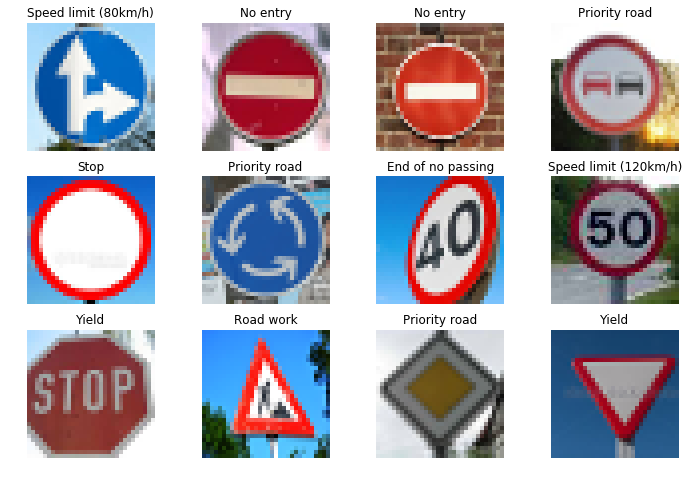

In [16]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

predictions = predict(images)
for pred in predictions:
    print('{} - {}'.format(pred, sign_names[pred]))
    
plt.figure(figsize=(12, 8))
for i in range(len(original_images)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(original_images[i]) 
    plt.title(sign_names[predictions[i]])
    plt.axis('off')
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

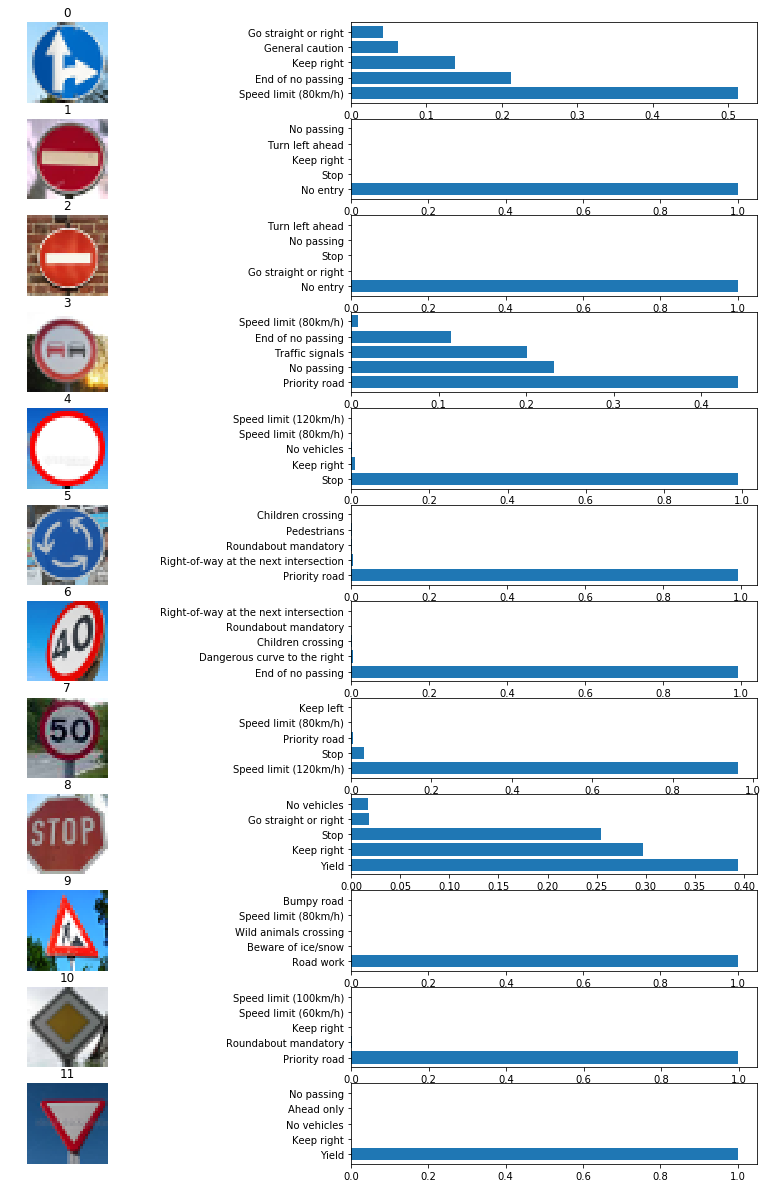

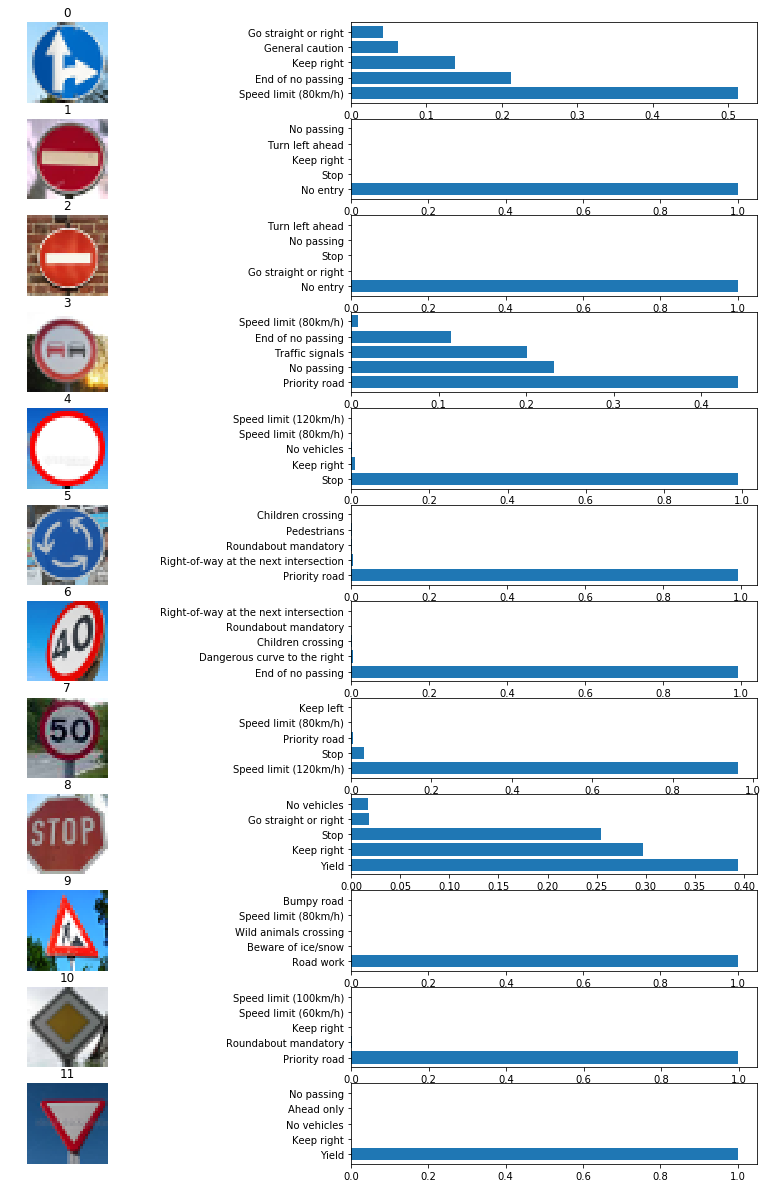

In [18]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
def calculate_top(images=images, k=5):
    # TODO Use the same session here!
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_filename)
        predictions = sess.run(tf.nn.softmax(logits), feed_dict={x: images, keep_prob: 1.0})
        top_k = sess.run(tf.nn.top_k(predictions, k))
        return top_k

top_five = calculate_top(images=images, k=5)


def show_images_top_predictions(images):
    plt.figure(figsize=(16, 21))
    for i in range(len(images)):
        plt.subplot(12, 2, 2*i+1)
        plt.imshow(images[i])
        plt.title(i)
        plt.axis('off')
        plt.subplot(12, 2, 2*i+2)
        plt.barh(np.arange(1, 6, 1), top_five.values[i, :])
        labs=[sign_names[j] for j in top_five.indices[i]]
        plt.yticks(np.arange(1, 6, 1), labs)
    plt.show()
    
show_images_top_predictions(original_images)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [19]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(sess, image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess)
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15, 15))
    for featuremap in range(featuremaps):
        plt.subplot(6, 8, featuremap + 1)  # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap))  # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmin=activation_min,
                       vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min != -1:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", cmap="gray")

    if show_images:
        plt.show()

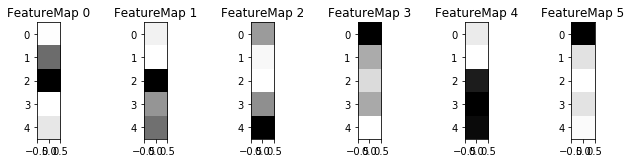

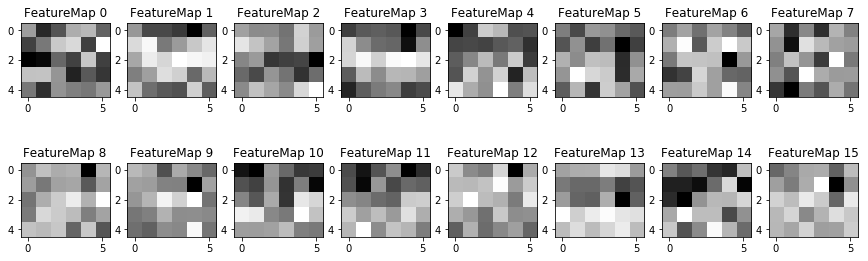

In [20]:
tf.reset_default_graph()
with tf.variable_scope('conv1', reuse=True):
    layer1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=0., stddev=0.1), name='weights')

with tf.variable_scope('conv2'):
    layer2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=0., stddev=0.1), name='weights')

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_filename)

    outputFeatureMap(sess, [images[0]], layer1)
    outputFeatureMap(sess, [images[0]], layer2)
